#Predicting Financial Impact of Car Part Delays

## Step 1 : Importing Libraries

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

## Loading the Dataset

In [2]:
# Step 2: Load dataset
df = pd.read_csv("Financial_Impact_Regression_Final_Dataset.csv")

In [3]:
# Step 3: Basic overview
print("Shape of data:", df.shape)
df.head()

Shape of data: (1010, 73)


,Engine_Supplier_Region,Engine_Transport_Mode,Is_Critical_Engine,Transmission_Supplier_Region,Transmission_Transport_Mode,Is_Critical_Transmission,Brake_System_Supplier_Region,Brake_System_Transport_Mode,Is_Critical_Brake_System,Suspension_Supplier_Region,...,Critical_Brake_x_Delay,Critical_Susp_x_Delay,Critical_Info_x_Delay,Urgency_x_TotalDelayed,Holiday_x_CriticalDelay,Strike_x_TotalDelayed,Weather_x_TotalDelayed,Is_Any_Part_Delayed,All_Parts_On_Time,All_Critical_Parts_On_Time
0,EAST,ROAD,1,NORTH,ROAD,0,SOUTH,SEA,1,EAST,...,1,1,0,MEDIUMMEDIUMMEDIUM,0,0,STORMSTORMSTORM,1,0,0
1,NORTH,SEA,1,EAST,AIR,1,EAST,SEA,1,NORTH,...,0,0,0,MEDIUMMEDIUM,0,0,CLEARCLEAR,1,0,1
2,WEST,AIR,0,EAST,AIR,1,EAST,AIR,0,WEST,...,0,0,0,NaN,0,0,NaN,0,1,1
3,EAST,ROAD,0,EAST,ROAD,1,NORTH,SEA,1,WEST,...,1,0,1,HIGHHIGHHIGHHIGH,0,0,CLEARCLEARCLEARCLEAR,1,0,0
4,SOUTH,AIR,0,SOUTH,AIR,0,NORTH,AIR,1,SOUTH,...,0,0,0,LOW,0,0,CLEAR,1,0,1


## Quick Summary of Columns & Target

In [4]:
# Check data types and missing values
df.info()

# Summary of target variable
df['Financial_Impact_USD'].describe()

# Check how many 0s in target
print("Zero financial impact rows:", (df['Financial_Impact_USD'] == 0).sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010 entries, 0 to 1009
Data columns (total 73 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Engine_Supplier_Region            1010 non-null   object 
 1   Engine_Transport_Mode             1010 non-null   object 
 2   Is_Critical_Engine                1010 non-null   int64  
 3   Transmission_Supplier_Region      1010 non-null   object 
 4   Transmission_Transport_Mode       1010 non-null   object 
 5   Is_Critical_Transmission          1010 non-null   int64  
 6   Brake_System_Supplier_Region      1010 non-null   object 
 7   Brake_System_Transport_Mode       1010 non-null   object 
 8   Is_Critical_Brake_System          1010 non-null   int64  
 9   Suspension_Supplier_Region        1010 non-null   object 
 10  Suspension_Transport_Mode         1010 non-null   object 
 11  Is_Critical_Suspension            1010 non-null   int64  
 12  Infota

## Visualize Target Distribution

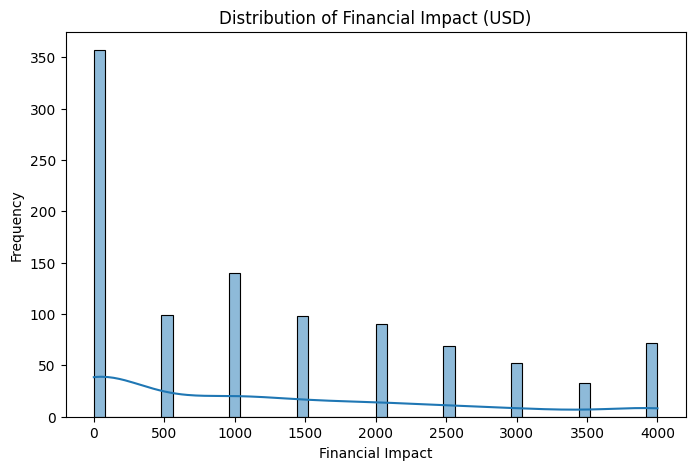

In [5]:
# Distribution of target
plt.figure(figsize=(8,5))
sns.histplot(df['Financial_Impact_USD'], bins=50, kde=True)
plt.title("Distribution of Financial Impact (USD)")
plt.xlabel("Financial Impact")
plt.ylabel("Frequency")
plt.show()

## Handle Missing Values

In [6]:
# Check missing values
missing = df.isnull().sum()
missing[missing > 0].sort_values(ascending=False)

,0
Order_Urgency_Num,1010
Delay_Per_Urgency,1010
Non_Critical_Parts_Delayed_Ratio,95
Urgency_x_TotalDelayed,20
Weather_x_TotalDelayed,20
Critical_Parts_Ratio,7


In [7]:
# Drop completely empty columns
df.drop(columns=['Order_Urgency_Num', 'Delay_Per_Urgency'], inplace=True)


# Fill specific ratios with 0 (no delays = 0% ratio)
fill_zero_cols = ['Non_Critical_Parts_Delayed_Ratio', 'Urgency_x_TotalDelayed',
                  'Weather_x_TotalDelayed', 'Critical_Parts_Ratio']

df[fill_zero_cols] = df[fill_zero_cols].fillna(0)

In [8]:
# Confirm cleanup
print("Missing values after cleaning:\n", df.isnull().sum().sum())

Missing values after cleaning:
 0


## Define Target and Features


In [9]:
# Define target and input features
y = df['Financial_Impact_USD']
X = df.drop(columns=['Financial_Impact_USD'])

## Understand Feature Types

In [10]:
# Step: Classify columns properly
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:\n", categorical_cols)
print("\nNumerical columns:\n", numerical_cols)

Categorical columns:
 ['Engine_Supplier_Region', 'Engine_Transport_Mode', 'Transmission_Supplier_Region', 'Transmission_Transport_Mode', 'Brake_System_Supplier_Region', 'Brake_System_Transport_Mode', 'Suspension_Supplier_Region', 'Suspension_Transport_Mode', 'Infotainment_Supplier_Region', 'Infotainment_Transport_Mode', 'Order_Urgency', 'Weather_Condition_On_Delivery', 'Production_Shift', 'Route_Type', 'Traffic_Level', 'Engine_Supplier_Group', 'Transmission_Supplier_Group', 'Brake_System_Supplier_Group', 'Suspension_Supplier_Group', 'Infotainment_Supplier_Group', 'Urgency_x_TotalDelayed', 'Weather_x_TotalDelayed']

Numerical columns:
 ['Is_Critical_Engine', 'Is_Critical_Transmission', 'Is_Critical_Brake_System', 'Is_Critical_Suspension', 'Is_Critical_Infotainment', 'Engine_Delayed_Flag', 'Transmission_Delayed_Flag', 'Brake_System_Delayed_Flag', 'Suspension_Delayed_Flag', 'Infotainment_Delayed_Flag', 'Any_Critical_Part_Delayed', 'Holiday_Proximity', 'Strike_Notice', 'Total_Parts_Delayed

Categorical and numerical columns are treated differently during modeling. Tree-based models like CatBoost handle categoricals natively, while others may require encoding.



## Split the Dataset for Training and Testing

In [11]:
# Use 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)

Training data shape: (808, 70)
Testing data shape: (202, 70)


Train-Test Split Rationale:

80/20 split is standard.

random_state=42 ensures reproducibility.

##Categorical Encoding + Feature Scaling


In [12]:
# Encode categorical features using one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns (ensure train & test have same feature set)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)


In [13]:
# Standardize numerical features
scaler = StandardScaler()
X_train_encoded[numerical_cols] = scaler.fit_transform(X_train_encoded[numerical_cols])
X_test_encoded[numerical_cols] = scaler.transform(X_test_encoded[numerical_cols])


Why this is important:

- Prevents data leakage during encoding.

- Scaling improves convergence for some algorithms (like linear models or KNN).

- Aligning keeps feature sets consistent.

## Random Forest Regressor (Baseline)

In [14]:
# Create and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

RandomForestRegressor(random_state=42)

In [15]:
# Predict
y_pred = rf_model.predict(X_test_encoded)

In [16]:
# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("R2 Score:", round(r2, 3))
print("Mean Absolute Error (MAE):", round(mae, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))


R2 Score: 0.752
Mean Absolute Error (MAE): 521.14
Root Mean Squared Error (RMSE): 637.74


## LightGBM Hyperparameter Tuning with GridSearchCV

In [23]:
lgbm = lgb.LGBMRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7, -1],  # -1 means no limit
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'subsample': [0.6, 0.8, 1.0]
}

grid_search_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid,
                               cv=3, n_jobs=-1, verbose=2, scoring='r2')
# Replace spaces with underscores in column names
X_train_encoded.columns = X_train_encoded.columns.str.replace(' ', '_')
best_lgbm= grid_search_lgbm.fit(X_train_encoded, y_train)
y_pred_lgbm = best_lgbm.predict(X_test_encoded)

mae = mean_absolute_error(y_test, y_pred_lgbm)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print("Best LightGBM Params:", grid_search_lgbm.best_params_)
print("Best LightGBM R2:", grid_search_lgbm.best_score_)
print(f"Best LightGBM MAE: {mae:.2f}")
print(f"Best LightGBM RMSE: {rmse:.2f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 808, number of used features: 161
[LightGBM] [Info] Start training from score 1240.099010
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

## CatBoost Regressor with Categorical Features

In [20]:
# Define features and target
X = df.drop(columns=['Financial_Impact_USD'])
y = df['Financial_Impact_USD']


# List of categorical columns
categorical_cols = [
    'Engine_Supplier_Region', 'Engine_Transport_Mode',
    'Transmission_Supplier_Region', 'Transmission_Transport_Mode',
    'Brake_System_Supplier_Region', 'Brake_System_Transport_Mode',
    'Suspension_Supplier_Region', 'Suspension_Transport_Mode',
    'Infotainment_Supplier_Region', 'Infotainment_Transport_Mode',
    'Order_Urgency', 'Weather_Condition_On_Delivery',
    'Production_Shift', 'Route_Type', 'Traffic_Level',
    'Engine_Supplier_Group', 'Transmission_Supplier_Group',
    'Brake_System_Supplier_Group', 'Suspension_Supplier_Group',
    'Infotainment_Supplier_Group',
    'Urgency_x_TotalDelayed', 'Weather_x_TotalDelayed'
]

#Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

#Initialize CatBoostRegressor
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_seed=42,
    verbose=100
)

# Fit model with categorical features
cat_model.fit(
    X_train, y_train,
    cat_features=categorical_cols,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=50
)

#Predict and evaluate
y_pred = cat_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"CatBoost R2 Score: {r2:.3f}")
print(f"CatBoost MAE: {mae:.2f}")
print(f"CatBoost RMSE: {rmse:.2f}")


0:	learn: 1246.0098846	test: 1244.5300783	best: 1244.5300783 (0)	total: 48.8ms	remaining: 48.8s
100:	learn: 617.7088975	test: 624.5712870	best: 624.5712870 (100)	total: 2.39s	remaining: 21.3s
200:	learn: 555.8657302	test: 607.6042213	best: 606.9796165 (192)	total: 3.9s	remaining: 15.5s
300:	learn: 498.9032024	test: 604.9452544	best: 603.5035950 (260)	total: 5.42s	remaining: 12.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 603.503595
bestIteration = 260

Shrink model to first 261 iterations.
CatBoost R2 Score: 0.778
CatBoost MAE: 513.07
CatBoost RMSE: 603.50


Output Summary:

CatBoost R² Score: 0.78

MAE: $513

RMSE: $604

Stopped early at iteration 261 due to early stopping to prevent overfitting.

In [21]:
#Saving the model
cat_model.save_model("catboost_financial_impact_model.cbm")
print("Model saved successfully!")

Model saved successfully!


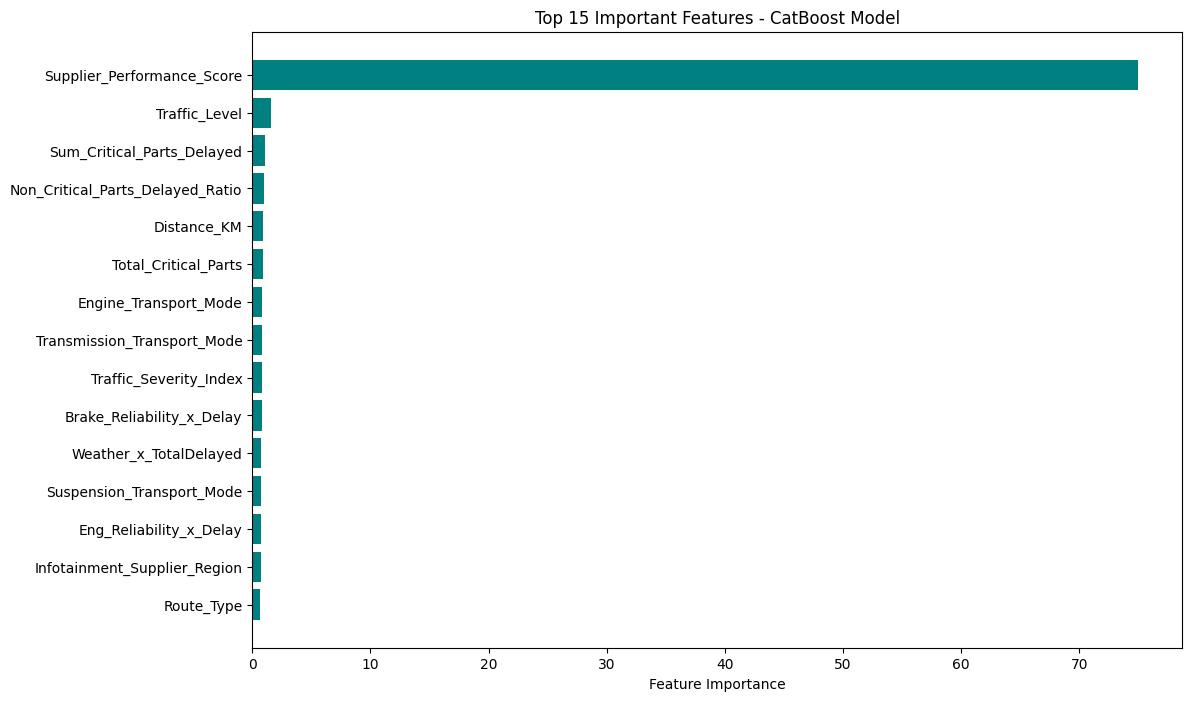

In [22]:
feature_importances = cat_model.get_feature_importance()
feature_names = X_train.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12,8))
plt.barh(fi_df['Feature'][:15][::-1], fi_df['Importance'][:15][::-1], color='teal')
plt.xlabel('Feature Importance')
plt.title('Top 15 Important Features - CatBoost Model')
plt.show()

## Model Performance Summary

| Model         | R² Score | MAE (Mean Absolute Error) | RMSE (Root Mean Squared Error) | Notes |
|---------------|----------|---------------------------|--------------------------------|-------|
| Random Forest | 0.75     | $521                      | $638                           | Strong baseline, captures complex relationships well. |
| LightGBM      | 0.70     | $530.13      | $633.11 | Tuned with GridSearchCV, good but below RF and CatBoost. Best params: learning_rate=0.01, max_depth=3, n_estimators=300, num_leaves=31, subsample=0.6. |
| CatBoost      | 0.78     | $513                      | $604                           | Best overall. Handles categorical data natively. Early stopping prevented overfitting. |

### Explanation:
- **R² Score** measures how well the model explains the variance in financial impact.
- **MAE** shows average absolute prediction error in dollars.
- **RMSE** penalizes larger errors more and shows typical prediction error magnitude.
- CatBoost outperforms others, with the lowest errors and highest R².
- LightGBM results are solid but slightly behind; calculating MAE and RMSE for LightGBM can help better compare.

### Recommendation:
Deploy **CatBoost** due to better accuracy and robustness with categorical features.
